In [1]:
# import libraries
import numpy as np
import pandas as pd
import os 

import math

from arch import arch_model
from scipy import stats

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats as sm_stat

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

In [2]:
# Set up folder with data:
os.chdir('D:\\00_PROJECTS_sripts_code\\Zmiennosc')

In [3]:
##########################################################
##########################################################
#%% Read data
##########################################################
##########################################################

In [4]:
# Read Analysis Data:
df_raw = pd.read_csv('bitcoin_daily.csv')

In [5]:
##########################################################
##########################################################
#%% Prepare data
##########################################################
##########################################################

In [6]:
df = df_raw\
        .assign(Date = lambda x: x['Date'].astype('datetime64[ns]') )\
        .dropna(subset=['Date'])\
        .sort_values('Date')\
        .set_index('Date')

df = df.dropna()

In [7]:
# check na
df.asfreq('d').isna().sum()

close    0
dtype: int64

In [8]:
# Calculate daily returns as percentage price changes
df['Return'] = 100 * (df[['close']].pct_change())
df.dropna(subset = ['Return'], inplace = True)

df['Variance'] = df['Return'].sub(df['Return'].mean()).pow(2)

print(df)

               close    Return   Variance
Date                                     
2017-08-18   4119.42 -4.816897  24.818745
2017-08-19   4139.98  0.499099   0.111659
2017-08-20   4124.44 -0.375364   0.291934
2017-08-21   4016.00 -2.629205   7.807274
2017-08-22   3977.39 -0.961404   1.268662
...              ...       ...        ...
2023-08-04  29068.24 -0.463061   0.394392
2023-08-05  29083.08  0.051052   0.012971
2023-08-06  29094.01  0.037582   0.016221
2023-08-07  29177.38  0.286554   0.014789
2023-08-08  29894.66  2.458343   5.259675

[2182 rows x 3 columns]


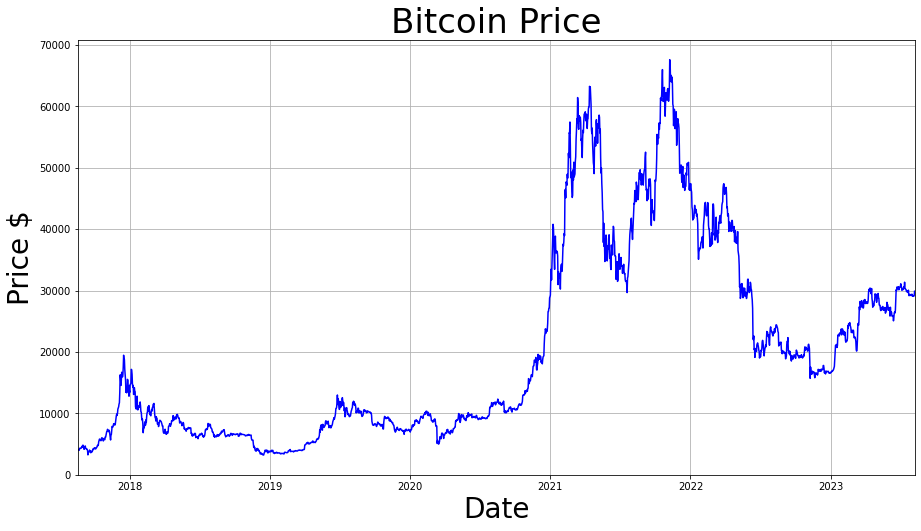

In [9]:
# Price Plot
fig = plt.figure(figsize=(15, 8))
plt.plot(df['close'], color = 'blue', label = 'Daily Returns')
plt.xlim(df.index[0], df.index[-1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.xlabel('Date', fontsize=28)
plt.ylabel('Price $', fontsize=28)
plt.title('Bitcoin Price', fontsize=34)
plt.grid(True)
plt.show()

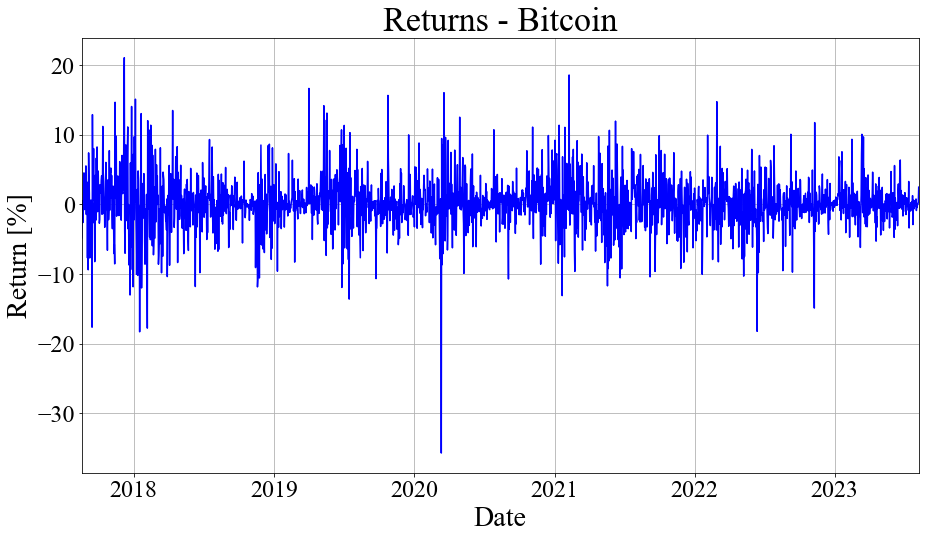

In [10]:
# Return Plot
fig = plt.figure(figsize=(15, 8))
plt.plot(df['Return'], color = 'blue', label = 'Daily Returns')
plt.xlim(df.index[0], df.index[-1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.xlabel('Date', fontsize=28)
plt.ylabel('Return [%]', fontsize=28)
plt.title('Returns - Bitcoin', fontsize=34)

plt.grid(True)
plt.show()

In [11]:
##########################################################
##########################################################
#%% Expanding rolling window
##########################################################
##########################################################

In [12]:
# Define Models
ModelSetUpAll = {'GARCH':  {'Name':'GARCH',
                            'vol': 'GARCH',
                            'mean':'constant',
                            'dist':'t',
                            'o':0},
                 'GJR-GARCH': {'Name':'GJR-GARCH',
                                'vol': 'GARCH',
                               'mean':'constant',
                               'dist':'t',
                               'o':1},
                'EGARCH': {'Name':'EGARCH',
                          'vol': 'EGARCH',
                          'mean':'constant',
                          'dist':'t',
                          'o':1}
                }

In [13]:
# Make forcast for all specified models:

ReturnData = df['Return']
TestDaysNr = 30
ResultsForecast = {}


for ModelName in ModelSetUpAll.keys():
    
    ModelSetUp = ModelSetUpAll[ModelName]
    
    forecasts = {}
    
    for i in range(TestDaysNr, 0, -1):
        
        # Specify EGARCH Model 
        Garch_Model = arch_model( ReturnData.iloc[:-i], p = 1, q = 1, o = ModelSetUp['o'],
                                  mean = ModelSetUp['mean'], vol = ModelSetUp['vol'], dist = ModelSetUp['dist'])
        
        Garch_Model_Fitted = Garch_Model.fit(disp = 'off')
        Forecast_temp = Garch_Model_Fitted.forecast(horizon=1, reindex = False).variance
        #Forecast_temp.index
        #Forecast_temp.values
        #fcast = temp.iloc[0]
        forecasts[ Forecast_temp.index[0] + datetime.timedelta(days=1)] = np.sqrt( Forecast_temp.iloc[0,0] )
        
    
    forecastsDF = pd.DataFrame.from_dict(forecasts, orient='index', columns = [f'Forecast - {ModelSetUp["Name"]}']).round(1)
    MAE = mean_absolute_error(df.loc[forecastsDF.index].Variance, forecastsDF**2).round(1)
    MSE = mean_squared_error(df.loc[forecastsDF.index].Variance, forecastsDF**2).round(1)
    RMSE = np.sqrt(mean_squared_error(df.loc[forecastsDF.index].Variance, forecastsDF**2)).round(1)
    
    ResultsForecast[ModelName] = {'Forecast':forecastsDF, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE }

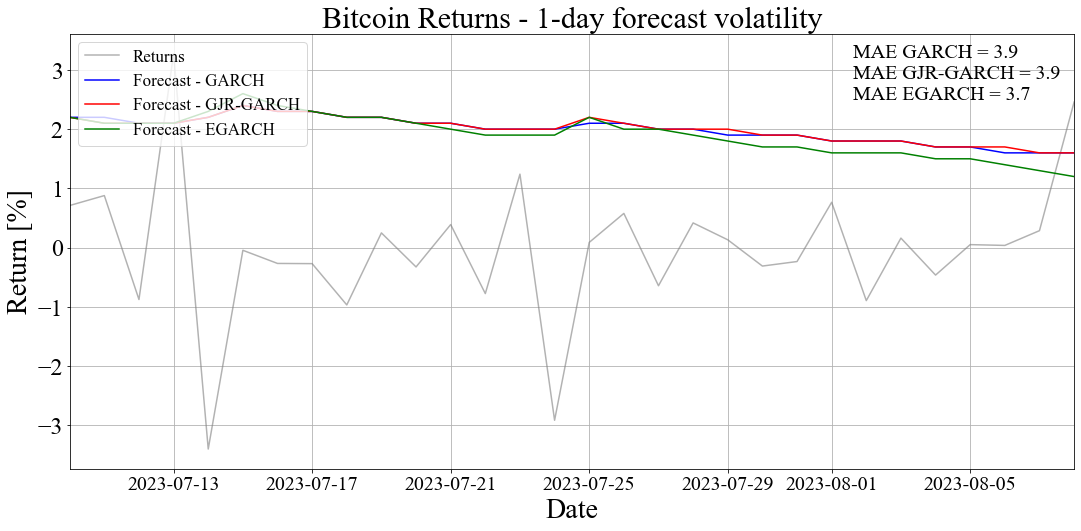

In [14]:
# Plot all data 

fig = plt.figure(figsize = (18, 8))
plt.plot(ReturnData.loc[ResultsForecast['GARCH']['Forecast'].index], alpha = 0.6, color = 'grey', label = 'Returns')
plt.plot(ResultsForecast['GARCH']['Forecast'], color = 'blue', label = 'Forecast - GARCH')
plt.plot(ResultsForecast['GJR-GARCH']['Forecast'], color = 'red', label = 'Forecast - GJR-GARCH')
plt.plot(ResultsForecast['EGARCH']['Forecast'], color = 'green', label = 'Forecast - EGARCH')

plt.xlim(ResultsForecast['GARCH']['Forecast'].index[0], ResultsForecast['GARCH']['Forecast'].index[-1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.xlabel('Date', fontsize=28)
plt.xticks(fontsize=20, rotation=0)
plt.ylabel('Return [%]', fontsize=28)
plt.title('Bitcoin Returns - 1-day forecast volatility', fontsize=30)
plt.legend(loc = 'upper left',  fontsize=17)

plt.text(0.78, 0.84, f'MAE GARCH = {ResultsForecast["GARCH"]["MAE"]} \nMAE GJR-GARCH = {ResultsForecast["GJR-GARCH"]["MAE"]}\nMAE EGARCH = {ResultsForecast["EGARCH"]["MAE"]}', 
         fontsize=20, fontfamily='Times New Roman', color='k',
         ha='left', va='bottom',
         transform=plt.gca().transAxes);


plt.grid(True)
plt.show()

In [15]:
##############################################################################
##############################################################################
### GARCH - fit model on whole dataset

In [16]:
### DEFINE MODELS:
# Specify GARCH model with t-student disribution (dist: 'normal', 't', 'skewt')
GarchModel = arch_model(df['Return'], p = 1, q = 1,
                        mean = 'constant', vol = 'GARCH', dist = 't')

# Specify GJR-GARCH Model 
GJRgarchModel = arch_model(df['Return'], p = 1, q = 1, o=1,
                        mean = 'constant', vol = 'GARCH', dist = 't')

# Specify EGARCH Model 
EgarchModel = arch_model(df['Return'], p = 1, q = 1, o=1,
                        mean = 'constant', vol = 'EGARCH', dist = 't')

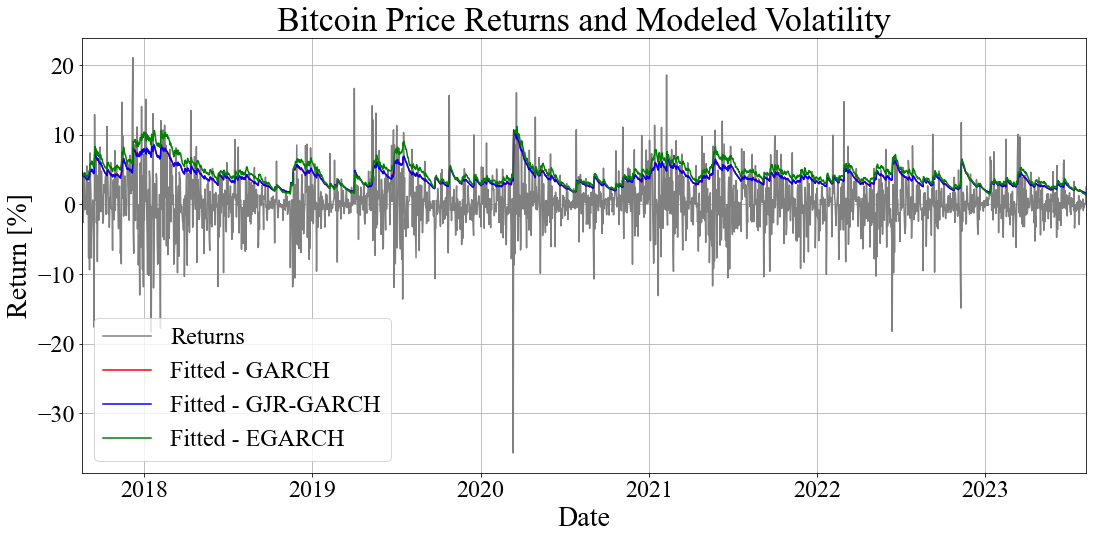

In [17]:
### Fit the model
gm_result = GarchModel.fit(update_freq=5, disp = 'off')
gjrgm_result = GJRgarchModel.fit(update_freq=5, disp = 'off')
egm_result = EgarchModel.fit(update_freq=5, disp = 'off')

# Get model estimated volatility
vol_fitted_garch = gm_result.conditional_volatility.rename('Fitted - GARCH')
vol_fitted_gjrgarch = gjrgm_result.conditional_volatility.rename('Fitted - GJR-GARCH')
vol_fitted_egarch = egm_result.conditional_volatility.rename('Fitted - EGARCH')

# Plot Fitted Volatility
fig = plt.figure(figsize = (18, 8))
plt.plot(df['Return'], color = 'grey', label = 'Returns')
plt.plot(vol_fitted_garch, color = 'red', label = 'Fitted - GARCH')
plt.plot(vol_fitted_gjrgarch, color = 'blue', label = 'Fitted - GJR-GARCH')
plt.plot(vol_fitted_egarch, color = 'green', label = 'Fitted - EGARCH')
plt.xlim(df.index[0], df.index[-1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.xlabel('Date', fontsize=28)
plt.ylabel('Return [%]', fontsize=28)
plt.title('Bitcoin Price Returns and Modeled Volatility', fontsize=34)
plt.legend(loc = 'lower left')
plt.grid(True)
plt.show()

In [18]:
#####################################################
#%% check model/residuals

results = egm_result

# Display model fitting summary
print(results.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5662.18
Distribution:      Standardized Student's t   AIC:                           11336.4
Method:                  Maximum Likelihood   BIC:                           11370.5
                                              No. Observations:                 2182
Date:                      Fri, Aug 11 2023   Df Residuals:                     2181
Time:                              02:16:39   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

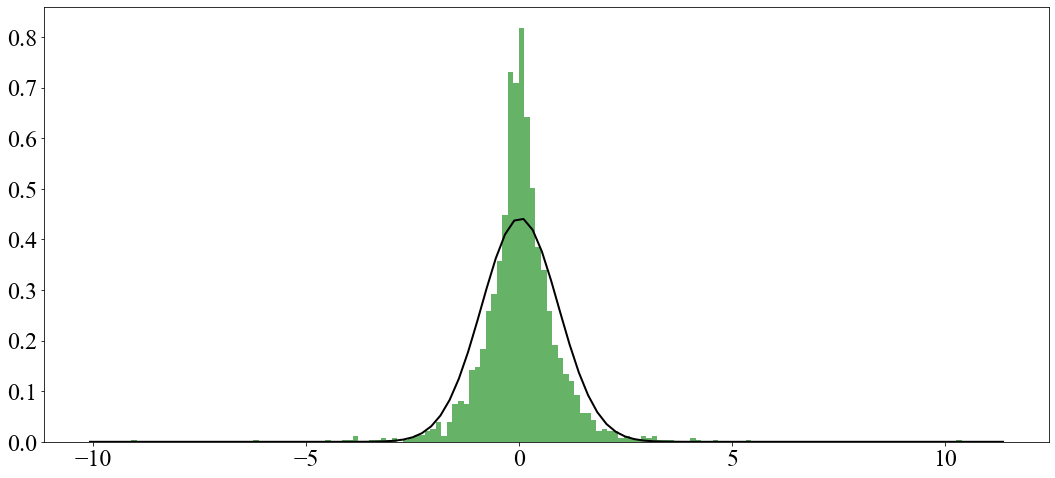

In [19]:
##############################################
### check distribution of residuals

from scipy.stats import norm

# Obtain model estimated residuals and volatility
gm_resid = results.resid
gm_std = results.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# fit norm distribution
mu, std = norm.fit(gm_std_resid)

# Plot the histogram.
fig = plt.figure(figsize = (18, 8))
plt.hist(gm_std_resid, bins=150, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [20]:
###  MODEL CHECK
# The standardized residuals should not exhibit data clustering or autocorrelations. 
# A GARCH model should resemble a white noise process.

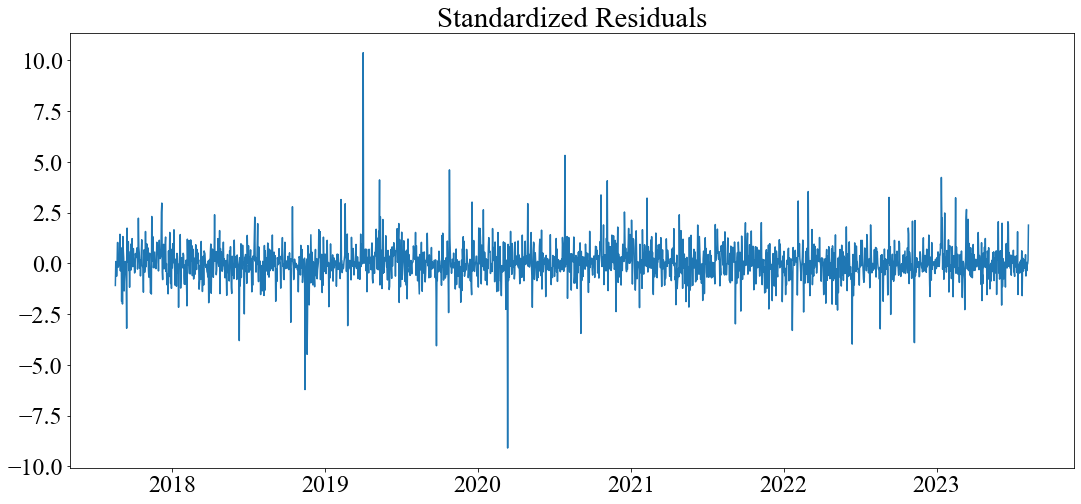

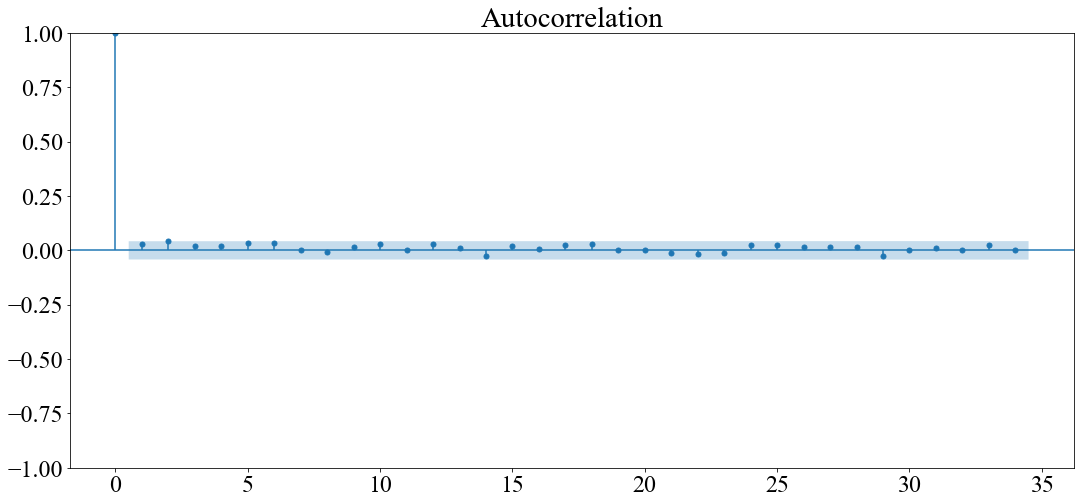

In [21]:
# Plot the standardized residuals
fig = plt.figure(figsize = (18, 8))
plt.plot(gm_std_resid)
plt.title('Standardized Residuals')
plt.show()

# Generate ACF plot of the standardized residuals
fig, ax = plt.subplots(figsize=(18, 8))
plot_acf(gm_std_resid, alpha = 0.05, ax=ax)
plt.show()

In [22]:
########### Ljung-Box test
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 10)
print(lb_test)

# Almost all the p-values are larger than 5% so the null hypothesis cannot be rejected. 
# In other words, no autocorrelations detected and the model is doing a decent job.

      lb_stat  lb_pvalue
1    2.027371   0.154488
2    5.892236   0.052543
3    6.852908   0.076737
4    7.824314   0.098230
5   10.429970   0.063930
6   12.875047   0.045064
7   12.875051   0.075212
8   13.020590   0.111143
9   13.436062   0.143847
10  15.126784   0.127507


In [23]:
########################################################
########################################################
#%% Forecast

In [24]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5, reindex = False)
gjrgm_forecast = gjrgm_result.forecast(horizon = 5, reindex = False)
egm_forecast = egm_result.forecast(horizon = 1, reindex = False)

# Print the forecast variance
print(gm_forecast.variance[-1:])
print(gjrgm_forecast.variance[-1:])
print(egm_forecast.variance[-1:])

forecast_dates_gm = pd.date_range(gm_forecast.variance[-1:].index[0], periods=6, freq='d')[1:]
vol_forecast_gm = pd.DataFrame(np.sqrt(gm_forecast.variance[-1:].T.values),\
                            index = forecast_dates_gm, columns = ['Forecast: GARCH'])
vol_forecast_gm = vol_forecast_gm.round(1)

forecast_dates_gjrgm = pd.date_range(gjrgm_forecast.variance[-1:].index[0], periods=6, freq='d')[1:]
vol_forecast_gjrgm = pd.DataFrame(np.sqrt(gjrgm_forecast.variance[-1:].T.values),\
                            index = forecast_dates_gjrgm, columns = ['Forecast: GJR - GARCH'])
vol_forecast_gjrgm = vol_forecast_gjrgm.round(1)

forecast_dates_egm = pd.date_range(egm_forecast.variance[-1:].index[0], periods=2, freq='d')[1:]
vol_forecast_egm = pd.DataFrame(np.sqrt(egm_forecast.variance[-1:].T.values),\
                            index = forecast_dates_egm, columns = ['Forecast: EGARCH'])
vol_forecast_egm = vol_forecast_egm.round(1)

                h.1       h.2       h.3       h.4       h.5
Date                                                       
2023-08-08  2.88786  3.005123  3.122386  3.239649  3.356911
                h.1       h.2       h.3       h.4       h.5
Date                                                       
2023-08-08  2.91643  3.039846  3.163261  3.286677  3.410092
                 h.1
Date                
2023-08-08  2.101649


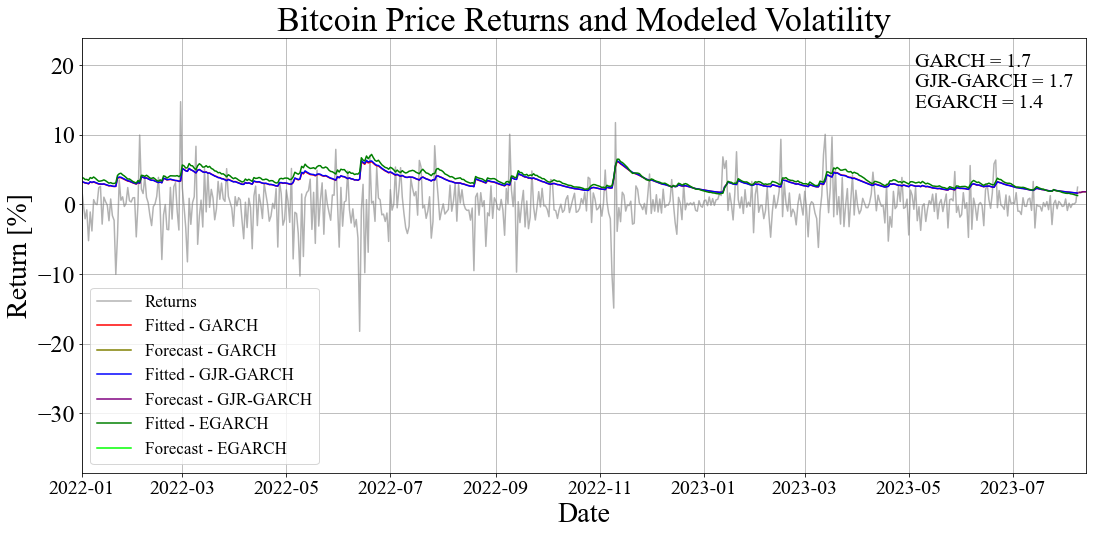

In [25]:
#%% Plot Fitted Volatility and Forecast

fig = plt.figure(figsize=(18, 8))
plt.plot(df['Return'], alpha = 0.6, color = 'grey', label = 'Returns')
plt.plot(vol_fitted_garch, color = 'red', label = 'Fitted - GARCH')
plt.plot(vol_forecast_gm, color = 'olive', label = 'Forecast - GARCH')
plt.plot(vol_fitted_gjrgarch, color = 'blue', label = 'Fitted - GJR-GARCH')
plt.plot(vol_forecast_gjrgm, color = 'purple', label = 'Forecast - GJR-GARCH')
plt.plot(vol_fitted_egarch, color = 'green', label = 'Fitted - EGARCH')
plt.plot(vol_forecast_egm, color = 'lime', label = 'Forecast - EGARCH')
plt.xlim(df.loc['2022':].index[0], vol_forecast_gm.index[-1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.xlabel('Date', fontsize=28)
plt.xticks(fontsize=20, rotation=0)
plt.ylabel('Return [%]', fontsize=28)
plt.title('Bitcoin Price Returns and Modeled Volatility', fontsize=34)
plt.legend(loc = 'lower left',  fontsize=17)
plt.text(0.83, 0.83, f'GARCH = {vol_forecast_gm.iloc[0,0]} \nGJR-GARCH = {vol_forecast_gjrgm.iloc[0,0]}\nEGARCH = {vol_forecast_egm.iloc[0,0]}', 
         fontsize=20, fontfamily='Times New Roman', color='k',
         ha='left', va='bottom',
         transform=plt.gca().transAxes);

plt.grid(True)
plt.show()

In [26]:
##########################################################
##########################################################
#%% Fixed rolling window
##########################################################
##########################################################

In [27]:
# Define Models
ModelSetUpAll_fixed = {'GARCH':  {'Name':'GARCH',
                                   'vol': 'GARCH',
                                   'mean':'constant',
                                   'dist':'t',
                                   'o':0},
                       'GJR-GARCH': {'Name':'GJR-GARCH',
                                        'vol': 'GARCH',
                                       'mean':'constant',
                                       'dist':'t',
                                       'o':1},
                       # 'EGARCH': {'Name':'EGARCH',
                       #            'vol': 'EGARCH',
                       #            'mean':'constant',
                       #            'dist':'t',
                       #            'o':1}
                       }

In [28]:
ReturnData = df['Return']

TrainDaysNr = 60
TestDaysNr = 60
ResultsForecast_Fixed = {}


# Make forcast for all specified models:
for ModelName in ModelSetUpAll_fixed.keys():
    
    ModelSetUp = ModelSetUpAll_fixed[ModelName]
    
    forecasts = {}
    
    for i in range(TestDaysNr, 0, -1):
        
        # Specify EGARCH Model 
        Garch_Model = arch_model( ReturnData.iloc[-(TrainDaysNr+i):-i], p = 1, q = 1, o = ModelSetUp['o'],
                                  mean = ModelSetUp['mean'], vol = ModelSetUp['vol'], dist = ModelSetUp['dist'])
        
        Garch_Model_Fitted = Garch_Model.fit(disp = 'off')
        Forecast_temp = Garch_Model_Fitted.forecast(horizon=1, reindex = False).variance
        #Forecast_temp.index
        #Forecast_temp.values
        #fcast = temp.iloc[0]
        forecasts[ Forecast_temp.index[0] + datetime.timedelta(days=1)] = np.sqrt( Forecast_temp.iloc[0,0] )
        
    
    forecastsDF = pd.DataFrame.from_dict(forecasts, orient='index', columns = [f'Forecast - {ModelSetUp["Name"]}']).round(1)
    MAE = mean_absolute_error(df.loc[forecastsDF.index].Variance, forecastsDF**2).round(1)
    MSE = mean_squared_error(df.loc[forecastsDF.index].Variance, forecastsDF**2).round(1)
    RMSE = np.sqrt(mean_squared_error(df.loc[forecastsDF.index].Variance, forecastsDF**2)).round(1)
    
    ResultsForecast_Fixed[ModelName] = {'Forecast':forecastsDF, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE }

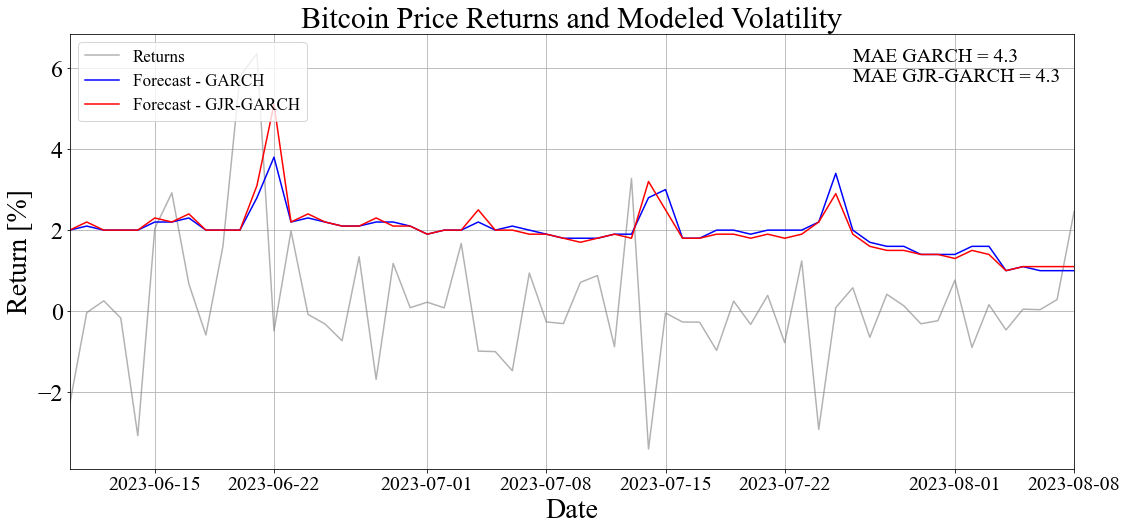

In [29]:
# Plot all data 

fig = plt.figure(figsize=(18, 8))
plt.plot(ReturnData.loc[ResultsForecast_Fixed['GARCH']['Forecast'].index], alpha = 0.6, color = 'grey', label = 'Returns')
plt.plot(ResultsForecast_Fixed['GARCH']['Forecast'], color = 'blue', label = 'Forecast - GARCH')
plt.plot(ResultsForecast_Fixed['GJR-GARCH']['Forecast'], color = 'red', label = 'Forecast - GJR-GARCH')
# plt.plot(ResultsForecast['EGARCH']['Forecast'], color = 'green', label = 'Forecast - EGARCH')

plt.xlim(ResultsForecast_Fixed['GARCH']['Forecast'].index[0], ResultsForecast_Fixed['GARCH']['Forecast'].index[-1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.xlabel('Date', fontsize=28)
plt.xticks(fontsize=20, rotation=0)
plt.ylabel('Return [%]', fontsize=28)
plt.title('Bitcoin Price Returns and Modeled Volatility', fontsize=30)
plt.legend(loc = 'upper left',  fontsize=17)

plt.text(0.78, 0.88, f'MAE GARCH = {ResultsForecast_Fixed["GARCH"]["MAE"]} \nMAE GJR-GARCH = {ResultsForecast_Fixed["GJR-GARCH"]["MAE"]}', 
         fontsize=20, fontfamily='Times New Roman', color='k',
         ha='left', va='bottom',
         transform=plt.gca().transAxes);


plt.grid(True)
plt.show()